In [52]:
import os
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_load import load_dataset
from plots import forecast_and_evaluate

Cargamos el el dataset

In [53]:
series,times = load_dataset('data_h')
series = series.reshape(-1,1) # array bidimensional para utilizar luego el MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1,1)) # los valores de la loss function son menoros con este rango que con (0,1)
series_scaled = scaler.fit_transform(series)

In [54]:
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

train_size = int(len(series) * train_percent)
val_size = int(len(series) * val_percent)

x_train = series[:train_size]
x_train_scaled = series_scaled[:train_size]
time_train = times[:train_size]

x_val = series[train_size:train_size + val_size]
x_val_scaled = series_scaled[train_size:train_size + val_size]
time_val = times[train_size:train_size + val_size]

x_test = series[train_size + val_size:]
x_test_scaled = series_scaled[train_size + val_size:]
time_test = times[train_size + val_size:]

Vamos a considerar los 3 mejores modelos: 

* Bidirectional_LSTM_alt ws=96 bs=16
* LSTM_Stacked_3_alt ws=96 bs=16
* LSTM_Stacked_3 ws=96 bs=32

Cargamos el modelo deseado

In [55]:
# Definir el nombre y la ruta del archivo del modelo guardado
model_name = 'LSTM_stacked_3_ws96_bs32.keras'
checkpoint_dir = 'Results/train_LSTM_stacked_3_ws96_bs32_results'
checkpoint_filepath = os.path.join(checkpoint_dir, model_name)

model = tf.keras.models.load_model(checkpoint_filepath, compile=False)
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_73 (LSTM)                  │ (None, 96, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 96, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,489 (373.00 KB)

 Trainable params: 95,489 (373.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
window_size = 24 * 4 # 4 days
num_features = 1
batch_size = 32
horizon = 24

In [57]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(x_train_scaled, 
                                      x_train_scaled, # Esta bien utilizar la demanda como entrada y como objetivo a la vez ya que es una prediccion univariada
                                      length=window_size,
                                      batch_size=batch_size)

validation_generator = TimeseriesGenerator(x_val_scaled,
                                           x_val_scaled,
                                           length=window_size,
                                           batch_size=batch_size)

# normalizamos tambien los datos de test ya que el modelo estara entrenado con datos normalizados por lo que no sera muy consistente realizarlo sin normalizar
test_generator = TimeseriesGenerator(x_test_scaled,
                                           x_test_scaled,
                                           length=window_size,
                                           batch_size=batch_size)

In [58]:
from models import predict

train_predict = predict(model,
                        train_generator,
                        scaler)

val_predict = predict(model,
                       validation_generator,
                       scaler)

test_predict = predict(model,
                       test_generator,
                       scaler)

c:\Users\daviddpp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step
 3/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step 

c:\Users\daviddpp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
 3/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 

c:\Users\daviddpp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Prediccion de los ultimos valores del conjunto de train

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Suma de las predicciones en el período de 24 steps: 4050.672091873287
Suma de los datos 

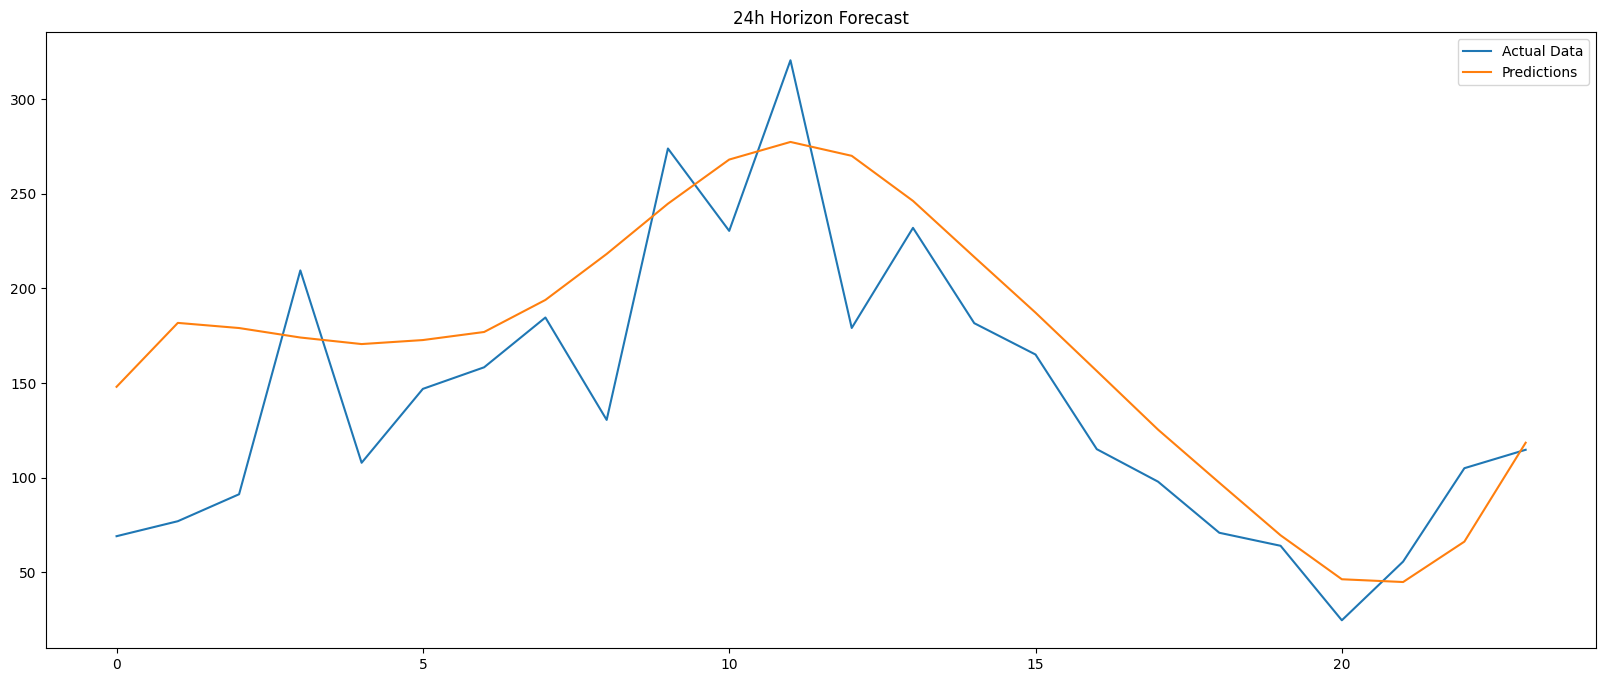

In [59]:
# Input: sequence of values (length = seq_size = 24)
prediction = [] #Empty list to populate later with predictions

current_batch = x_train_scaled[- window_size - 24 : -24] #Final data points in train 
current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

# Predict future, beyond train dates
horizon = 24 #Samples
for i in range(horizon):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

# Extract real data for the same period
real_data = series[len(x_train) - 24 : len(x_train) - 24 + horizon]

# Calculate the sum of the predictions and the real data
sum_predictions = np.sum(rescaled_prediction)
sum_real_data = np.sum(real_data)

# Calculate the relative error
relative_error = ( np.abs(sum_predictions - sum_real_data) / sum_real_data ) * 100

# Print the results
print('Suma de las predicciones en el período de 24 steps:', sum_predictions)
print('Suma de los datos reales en el período de 24 steps:', sum_real_data)
print(f'Error relativo entre la suma de las predicciones y los datos reales: {relative_error:.2f}%')

# print(f'Tramo {i+1} - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train MAPE: {train_mape:.2f}%')
 
plt.figure(figsize=(20,8))
plt.title('24h Horizon Forecast')
plt.plot(series[len(x_train) - 24 : len(x_train) -24 + horizon])
plt.plot(rescaled_prediction)
plt.legend(['Actual Data', 'Predictions'])
plt.show()

Prediccion de 24h usando el conjunto de test para las primeras 24h.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


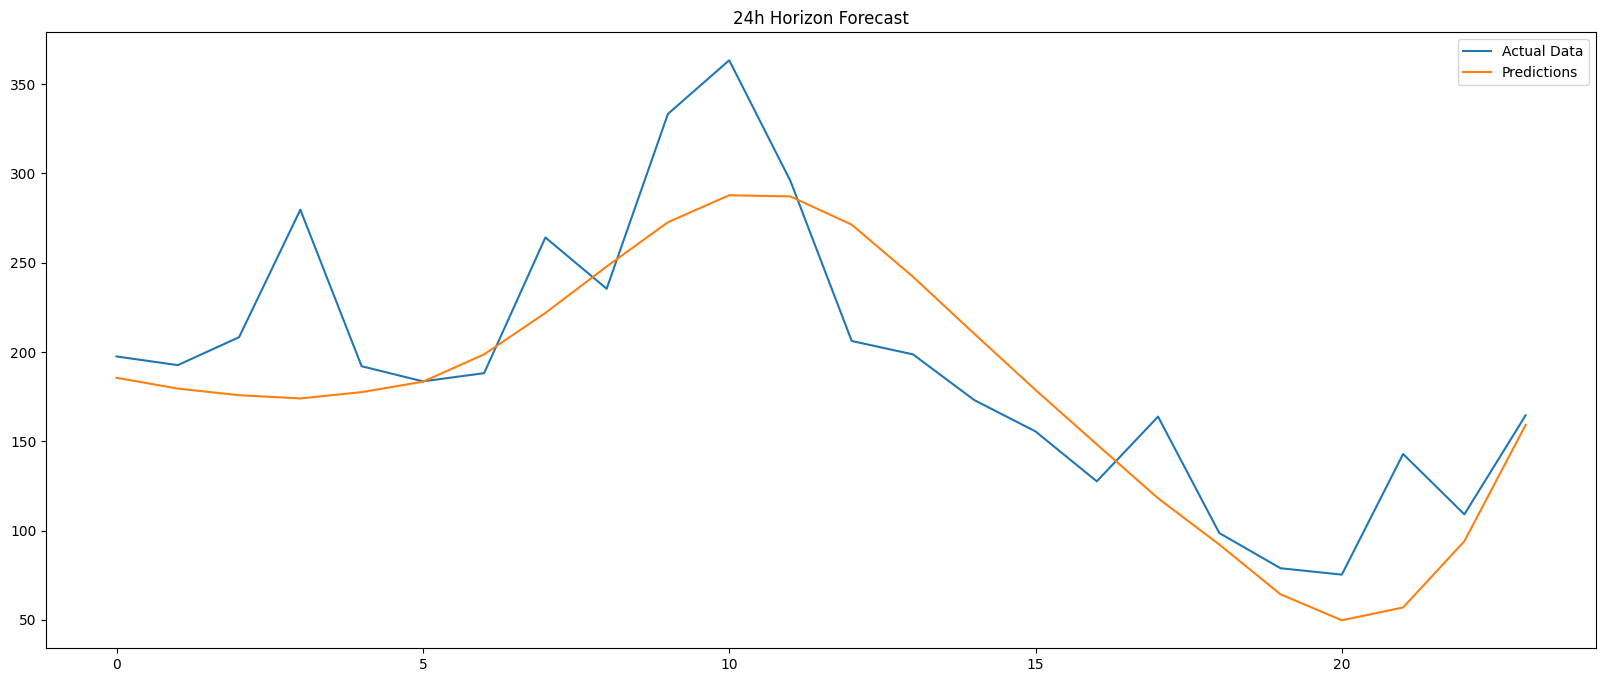

Error relativo entre la suma de las predicciones y los datos reales: 7.59%


In [60]:
horizon = 24  # Predicción para 24 pasos en el futuro
start = 0

from plots import forecast_and_evaluate
rescaled_prediction, real_data, relative_error = forecast_and_evaluate(start, x_test, x_test_scaled, model, scaler, window_size, num_features, horizon)

print(f'Error relativo entre la suma de las predicciones y los datos reales: {relative_error:.2f}%')



Prediccion de los 7 primeros dias del conjunto de test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

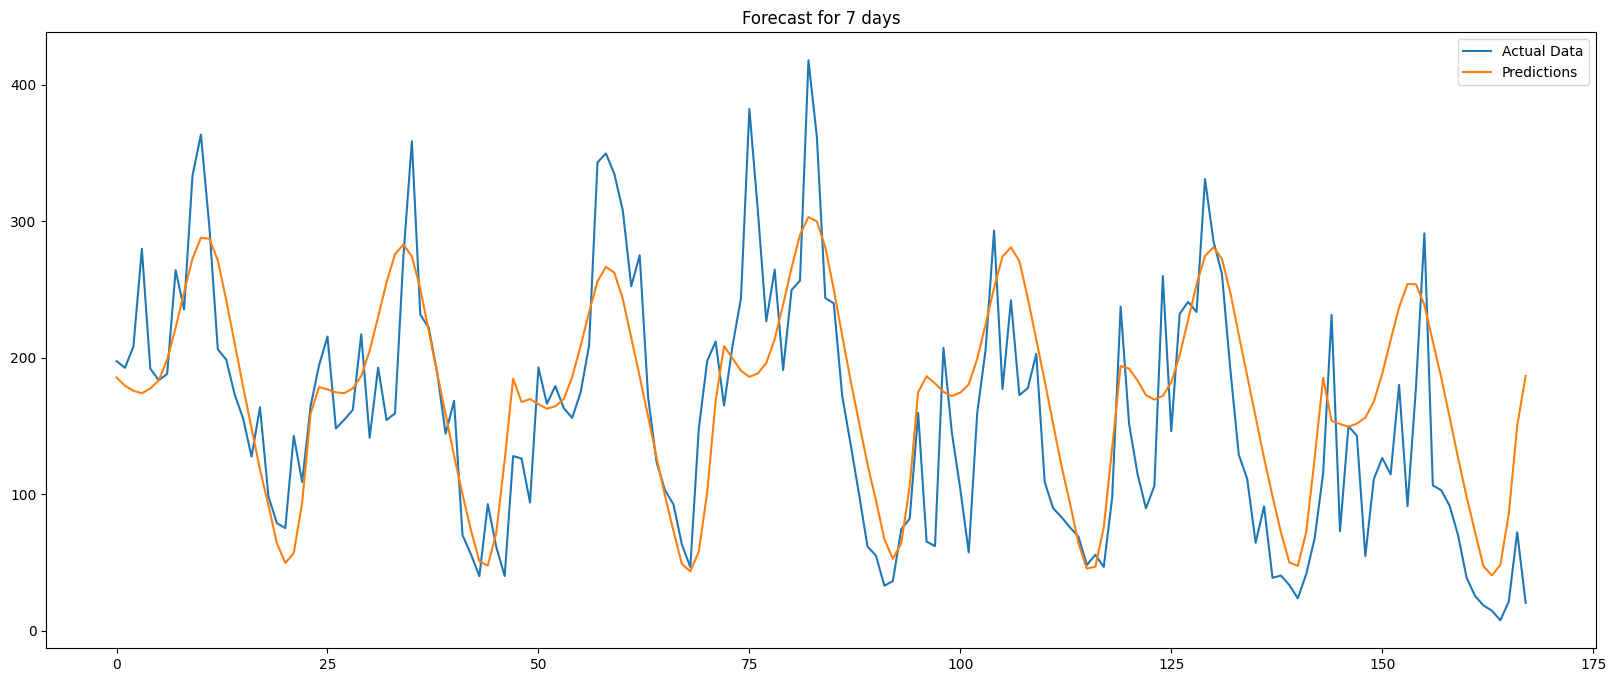

Dia 1, Error relativo: 7.59%
Dia 2, Error relativo: 9.82%
Dia 3, Error relativo: 12.22%
Dia 4, Error relativo: 2.66%
Dia 5, Error relativo: 29.87%
Dia 6, Error relativo: 22.56%
Dia 7, Error relativo: 59.44%


In [61]:
horizon = 24  # Predicción para 24 pasos en el futuro
max_start = 144 # Último valor de start

relative_errors = []

# Listas para acumular todas las predicciones y los datos reales
all_predictions = []
all_real_data = []

# Bucle para iterar a través de diferentes valores de start
for start in range(0, max_start + 1, 24):
    rescaled_prediction, real_data, relative_error = forecast_and_evaluate(start, x_test, x_test_scaled, model, scaler, window_size, num_features, horizon, plot=False)
    relative_errors.append(relative_error)
    
    # Acumular las predicciones y los datos reales
    all_predictions.extend(rescaled_prediction)
    all_real_data.extend(real_data)

# Convertir las listas a arrays numpy
all_predictions = np.array(all_predictions)
all_real_data = np.array(all_real_data)

# Plot final con todas las predicciones y datos reales
plt.figure(figsize=(20, 8))
plt.title(f'Forecast for {(max_start // 24) +1} days')
plt.plot(all_real_data, label='Actual Data')
plt.plot(all_predictions, label='Predictions')
plt.legend()
plt.show()

# Imprimir errores relativos
for i, start in enumerate(range(0, max_start + 1, 24)):
    print(f'Dia {(start // 24) +1}, Error relativo: {relative_errors[i]:.2f}%')

Calculamos el error relativo de todo el conjunto de test y tambien el promedio 

In [62]:
horizon = 24  # Predicción para 24 pasos en el futuro
max_start = 711  # Último valor de start ya que el start = 0 es en realidad el primer valor +  window size

# Lista para almacenar los errores relativos para cada start
relative_errors = []

# Bucle para iterar a través de diferentes valores de start
for start in range(0, max_start + 1, 24):
    rescaled_prediction, real_data, relative_error = forecast_and_evaluate(start, x_test, x_test_scaled, model, scaler, window_size, num_features, horizon, plot=False)
    relative_errors.append(relative_error)

# Imprimir errores relativos
for i, start in enumerate(range(0, max_start + 1, 24)):
    print(f'Dia: {start // 24}, Error relativo: {relative_errors[i]:.2f}%')

average_relative_error = np.mean(relative_errors)
print(f'Error relativo promedio: {average_relative_error:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━

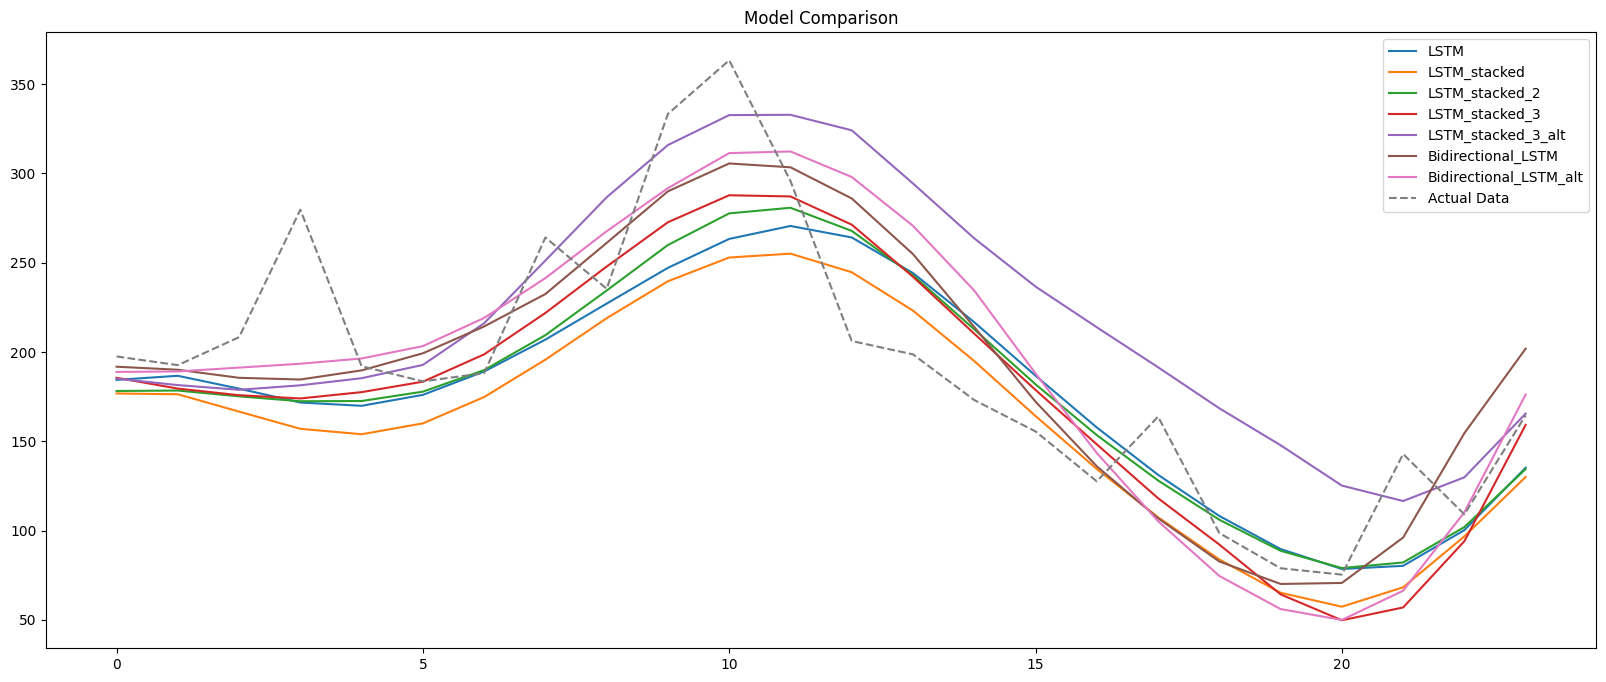

In [63]:
start = 0
model_names = ['LSTM',
                'LSTM_stacked',
                'LSTM_stacked_2',
                'LSTM_stacked_3',
                'LSTM_stacked_3_alt',
                'Bidirectional_LSTM',
                'Bidirectional_LSTM_alt'
                ]

plt.figure(figsize=(20, 8))

for model_name in model_names:
    model_path = f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results/{model_name}_ws{window_size}_bs{batch_size}.keras'
    model_comp = tf.keras.models.load_model(model_path, compile=False)

    current_batch = x_test_scaled[start : start + window_size]
    current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

    # Predict future
    prediction=[]
    for i in range(horizon):
        current_pred = model_comp.predict(current_batch)[0]
        prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    # Inverse transform to before scaling so we get actual values
    rescaled_predictions = scaler.inverse_transform(prediction)

    plt.plot(rescaled_predictions, label=model_name)

# Graficar los datos reales para comparación
plt.plot(x_test[start + window_size: start + window_size + horizon], '--', label='Actual Data')

# Configurar la leyenda y el título
plt.legend()
plt.title('Model Comparison')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━

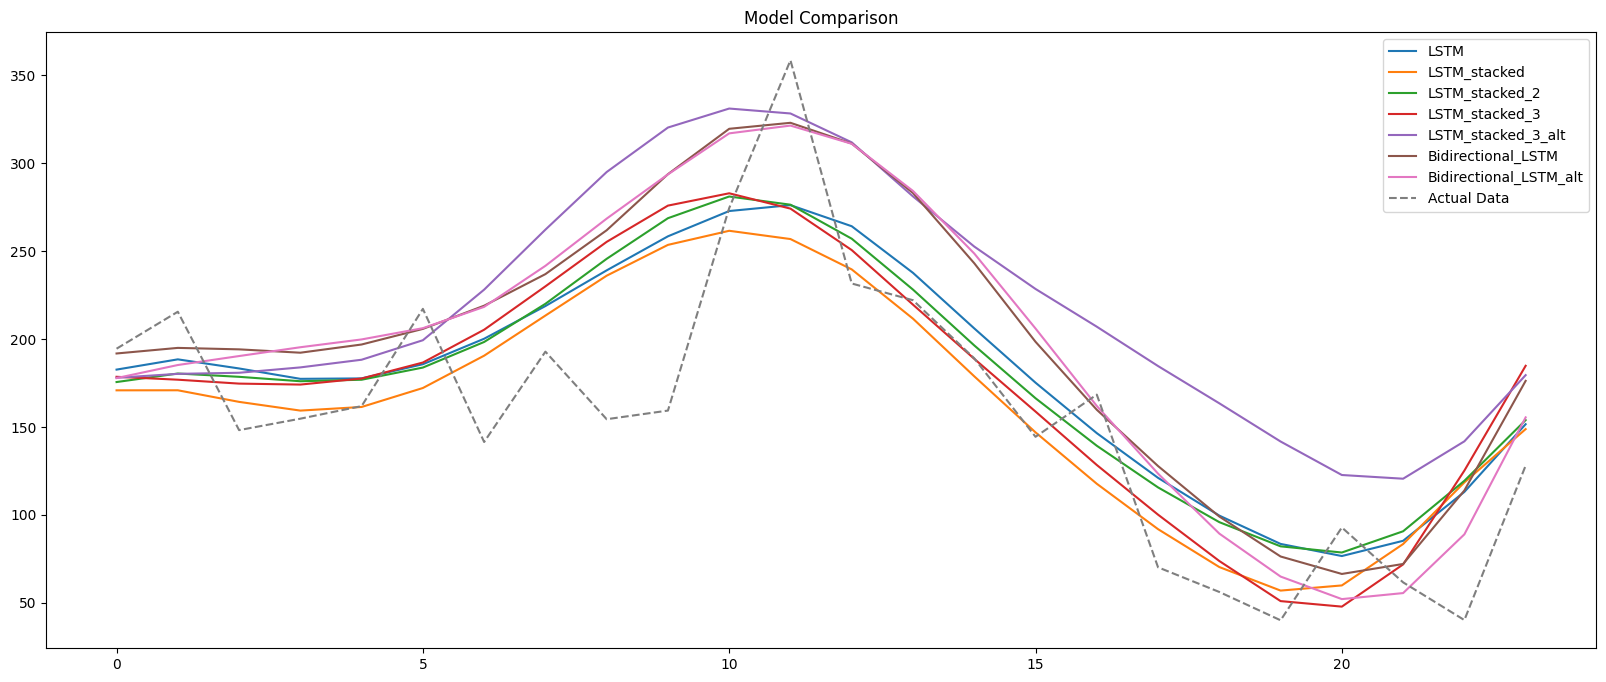

In [64]:
start = 24
model_names = ['LSTM',
                'LSTM_stacked',
                'LSTM_stacked_2',
                'LSTM_stacked_3',
                'LSTM_stacked_3_alt',
                'Bidirectional_LSTM',
                'Bidirectional_LSTM_alt'
                ]

plt.figure(figsize=(20, 8))

for model_name in model_names:
    model_path = f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results/{model_name}_ws{window_size}_bs{batch_size}.keras'
    model_comp = tf.keras.models.load_model(model_path, compile=False)

    current_batch = x_test_scaled[start : start + window_size]
    current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

    # Predict future
    prediction=[]
    for i in range(horizon):
        current_pred = model_comp.predict(current_batch)[0]
        prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    # Inverse transform to before scaling so we get actual values
    rescaled_predictions = scaler.inverse_transform(prediction)

    plt.plot(rescaled_predictions, label=model_name)

# Graficar los datos reales para comparación
plt.plot(x_test[start + window_size: start + window_size + horizon], '--', label='Actual Data')

# Configurar la leyenda y el título
plt.legend()
plt.title('Model Comparison')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━

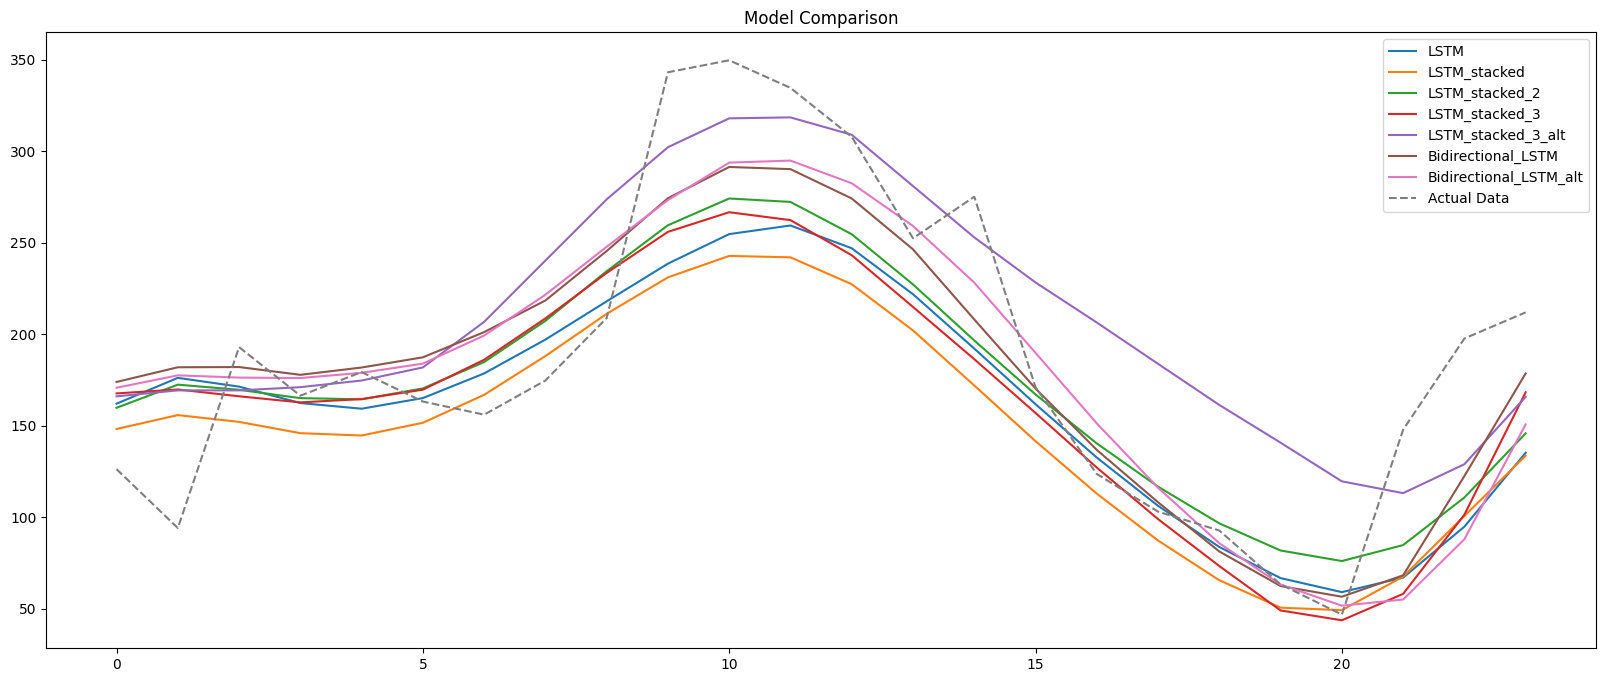

In [65]:
start = 48
model_names = ['LSTM',
                'LSTM_stacked',
                'LSTM_stacked_2',
                'LSTM_stacked_3',
                'LSTM_stacked_3_alt',
                'Bidirectional_LSTM',
                'Bidirectional_LSTM_alt'
                ]

plt.figure(figsize=(20, 8))

for model_name in model_names:
    model_path = f'Results/train_{model_name}_ws{window_size}_bs{batch_size}_results/{model_name}_ws{window_size}_bs{batch_size}.keras'
    model_comp = tf.keras.models.load_model(model_path, compile=False)

    current_batch = x_test_scaled[start : start + window_size]
    current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

    # Predict future
    prediction=[]
    for i in range(horizon):
        current_pred = model_comp.predict(current_batch)[0]
        prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    # Inverse transform to before scaling so we get actual values
    rescaled_predictions = scaler.inverse_transform(prediction)

    plt.plot(rescaled_predictions, label=model_name)

# Graficar los datos reales para comparación
plt.plot(x_test[start + window_size: start + window_size + horizon], '--', label='Actual Data')

# Configurar la leyenda y el título
plt.legend()
plt.title('Model Comparison')
plt.show()